## 雑に料理分類器を作ってみる

In [173]:
import pandas as pd

cuisine = [
    {
       'name': 'remen',
        'genre': 'chinese',
        'taste': ['spicy'],
        'hotorcold': 'cold',
    },
    {
       'name': 'baconeggs',
        'genre': 'western',
        'taste': ['salty'],
        'hotorcold': 'hot',
    },
    {
       'name': 'ebichili',
        'genre': 'chinese',
        'taste': ['spicy'],
        'hotorcold': 'hot',
    },
    {
       'name': 'oyakodon',
        'genre': 'japanese',
        'taste': ['salty', 'sweety'],
        'hotorcold': 'hot',
    },
]
cuisine_df = pd.DataFrame(cuisine)
cuisine_df.set_index('name')

,genre,hotorcold,taste
name,,,
remen,chinese,cold,[spicy]
baconeggs,western,hot,[salty]
ebichili,chinese,hot,[spicy]
oyakodon,japanese,hot,"[salty, sweety]"


### お試し決定木

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris

iris = load_iris()
model = DecisionTreeClassifier()
model.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

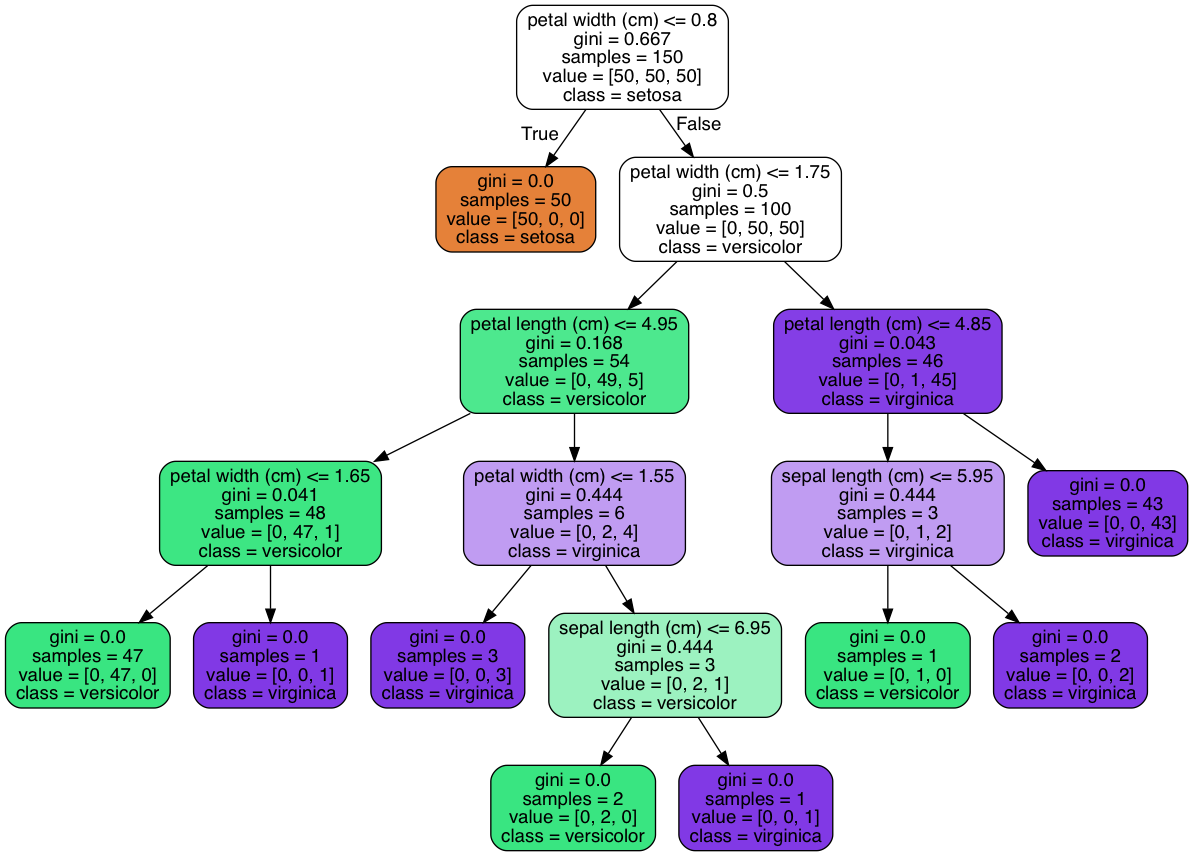

In [32]:
%matplotlib inline
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot_ng

dot_data = StringIO()
export_graphviz(model, 
                out_file=dot_data, 
                feature_names=iris.feature_names, 
                class_names=iris.target_names,
                filled=True,
                rounded=True,
               )
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### 料理データで決定木

### Preprocessing

In [56]:
"""nameの分類をしたいので、name以外のカラムを数値化していく（学習させるため）
カテゴリ変数->数値化は基本的にlabelbinarizerでok
"""

cuisine_df

,genre,hotorcold,name,taste
0,chinese,cold,remen,[spicy]
1,western,hot,baconeggs,[salty]
2,chinese,hot,ebichili,[spicy]
3,japanese,hot,oyakodon,"[salty, sweety]"


### genre

In [48]:
cuisine_df.genre

0     chinese
1     western
2     chinese
3    japanese
Name: genre, dtype: object

In [104]:
from sklearn.preprocessing import LabelBinarizer
lb_genre = LabelBinarizer()
labeled_genre = lb_genre.fit_transform(cuisine_df.genre)
labeled_genre, lb_genre.inverse_transform(labeled_genre)

(array([[1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]]), array(['chinese', 'western', 'chinese', 'japanese'],
       dtype='<U8'))

### hot or cold

In [105]:
lb_hotorcold = LabelBinarizer()
labeled_hotorcold = lb_hotorcold.fit_transform(cuisine_df.hotorcold)
labeled_hotorcold, lb_hotorcold.inverse_transform(labeled_hotorcold)

(array([[0],
        [1],
        [1],
        [1]]), array(['cold', 'hot', 'hot', 'hot'],
       dtype='<U4'))

### taste

In [110]:
"""このカラムは配列なのでMultiLaberBinalizerでないといけない
"""
from sklearn.preprocessing import MultiLabelBinarizer
lb_taste = MultiLabelBinarizer()
labeled_taste = lb_taste.fit_transform(cuisine_df.taste.values)
labeled_taste, lb_taste.inverse_transform(labeled_taste)

(array([[0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 1]]), [('spicy',), ('salty',), ('spicy',), ('salty', 'sweety')])

### name

In [93]:
"""最後に目的変数の料理名をID化
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(cuisine_df.name)
y, le.inverse_transform(y)

(array([3, 0, 1, 2]),
 array(['remen', 'baconeggs', 'ebichili', 'oyakodon'], dtype=object))

## concatenate labeled data

In [94]:
import numpy as np

X = np.concatenate((
    labeled_genre,
    labeled_hotorcold,
    labeled_taste,
), axis=1)
X, y

(array([[1, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [1, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 1, 0, 1]]), array([3, 0, 1, 2]))

## Training

In [95]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

model = DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [149]:
def create_feature_name(column_name):
    """カラム名->数値化したカラム名に変換
    """
    labels = eval('lb_{}'.format(column_name)).classes_
    if len(labels) <= 2:
        return ['{}__'.format(column_name)]
    else:
        return ['{}__{}'.format(column_name, label) for label in labels]

create_feature_name('genre') #,　create_feature_name('hotorcold')

['genre__chinese', 'genre__japanese', 'genre__western']

In [169]:
from itertools import chain

def flatten(l):
    return list(chain.from_iterable(l))

def create_feature_columns():
    return flatten([create_feature_name(name) for name in ['genre', 'hotorcold', 'taste']])

create_feature_columns()

['genre__chinese',
 'genre__japanese',
 'genre__western',
 'hotorcold__',
 'taste__salty',
 'taste__spicy',
 'taste__sweety']

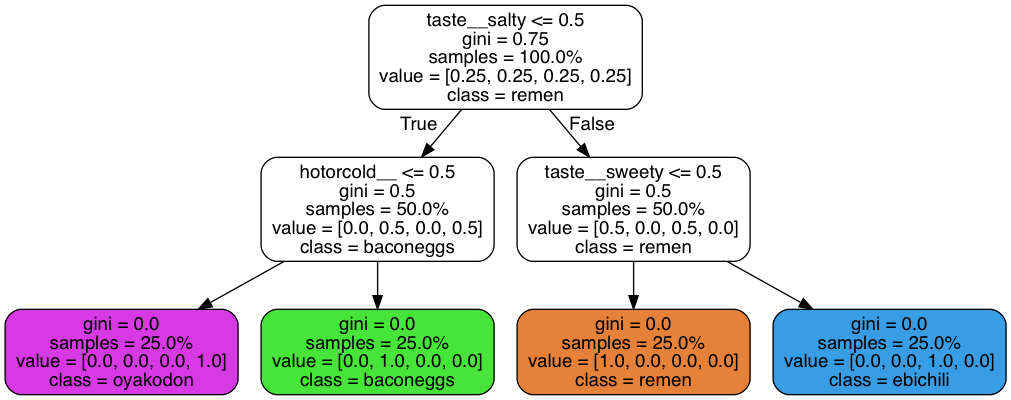

In [172]:
%matplotlib inline
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydot_ng

dot_data = StringIO()
export_graphviz(model, 
                out_file=dot_data, 
                feature_names=create_feature_columns(),
                class_names=le.inverse_transform(y),
                filled=True,
                rounded=True,
                proportion=True,
               )
graph = pydot_ng.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())